### TASK
Write a python module to periodically scan and parse news from newswire website. (20 Marks)
https://www.prnewswire.com/news-releases/news-releases-list/
Keep track of the already parsed news:  (20 Marks)
For all unparsed news, scan the content of the news to find a stock symbol.
e.g. (TSX:SHOP)
Scan the yahoo finance for the stock symbol appeared in the news. (30 Marks)
- Get the stock price and volume of last 5 days.
Prepare a nice visualization showing the News headline and Stock prices of last 5 days. (30 Marks)
- visualization should be a plot (time - series) for
- Volume
- Daily Close Price

['NYSE:IGT']


d:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Time:21:50 ET
Headline :International Game Technology PLC Announces Agreement To Sell Italian B2C Gaming Business For €950 Million In Cash
Stock :['NYSE:IGT']
['NYSE:IGT']


d:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Time:21:50 ET
Headline :International Game Technology PLC Announces Agreement To Sell Italian B2C Gaming Business For €950 Million In Cash
Stock :['NYSE:IGT']


KeyboardInterrupt: 

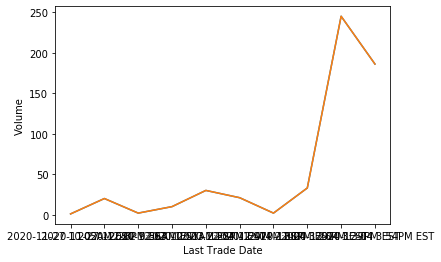

In [16]:
from lxml.html import parse
from pandas.io.parsers import TextParser
from urllib.request import urlopen
import urllib
import requests
from lxml import html
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import re
import time
import logging


class newsCrawler:
    def __init__(self):
        url = 'https://www.prnewswire.com/news-releases/news-releases-list/'
        hdr = {'User-Agent':'Mozilla/5.0'}
        self.stockSymbol=['TSE','NASDAQ','TSX','NSE:','NYSE','TSXV:']

        req = urllib.request.Request(url,headers=hdr)
        page = urlopen(req)
        docTree = parse(page)
        doc = docTree.getroot()
        
        self._persistentDF= pd.read_csv('news.csv') 
        self.oldDF=pd.DataFrame(columns =['TIme', 'Heading', 'News_content', 'listofsymbol', 'DateNews'])
        #print(doc.text)
        self.lDataforViz = []
        
    ### converting div to dataframe
    def getNews(self,parent):
        d={}
        l=[]
        uniqueList=[]

        strp=str(parent.text_content())       
        
        for element in parent.iter():
            if (element.tag == 'p'):
                d.update({'News_content' : element.text})
            elif (element.tag == 'a'):
                d.update({'Heading' : element.text})
            elif (element.tag == 'small'):
                d.update({'TIme': element.text}) 
            else: 
                pass             
        ## change this later - pass stock tickers
        lstofSymbol = re.findall(r"\(((?:TSX|NASDAQ|TSXV|NSE|TSE|NYSE)[:A-Za-z0-9_\s-]+)",  strp)
        l.extend(lstofSymbol)

        ## remove duplicates from list
        [uniqueList.append(x) for x in l if x not in uniqueList] 
        d.update({'listofsymbol' : uniqueList , 'DateNews':pd.to_datetime('today').date()})
        
        return d
    
    def isRowAlreadyProcessed(self,Cval,currentDF):
        df=currentDF.loc[currentDF['Heading'] == Cval]
        return not df.empty
        
    ##stockSymbol=['TSE','BSE','NSE:','NYSE','TSXV:']
    def FindAllNews(self,liststockSymbol):
        url = 'https://www.prnewswire.com/news-releases/news-releases-list/'
        hdr = {'User-Agent':'Mozilla/5.0'}
        req = urllib.request.Request(url,headers=hdr)
        page = urlopen(req)
        docTree = parse(page)
        doc = docTree.getroot()
        currentDF=pd.DataFrame()
                
        dic={}
        allData=[]
        df=pd.DataFrame()

        ##find all parents elements
        for s in liststockSymbol:
            #print(s)
            kind=s
            Htmltags = docTree.xpath('.//*[contains(text(),"%s")]' % kind)
            listofDivs=[h.getparent() for h in Htmltags]

            ## create a list of dictionaries , 1 for each div element
            for div in listofDivs:
                allData.append(self.getNews(div))                
        return allData
 

    ##
    ## return a list of dataframe
    ##
    def getSymbolsfromNews(self):
        
        lDataforViz=[] 
        currDF = pd.DataFrame(self.FindAllNews(self.stockSymbol))
        
        for index, row in currDF.iterrows():
            print(row['listofsymbol'])
            if(self.isRowAlreadyProcessed(row['Heading'],self.oldDF)):
                continue
                ## if row is not already proocessed dispaly viz
            self.displayVisualization(row)
            
        return lDataforViz
    
    def displayVisualization(self,row):
        kplots=4
        vizlst=[]
        
        
        for s in row['listofsymbol']:
            yahooDF=self.yahoo_finance_df(s.strip().split(':')[1])
            yahooDF=yahooDF.sort_values(by=['Last Trade Date'], ascending=False).tail(50)                     
            insertd={'symobol':s,'textrow':row,'dataDF': yahooDF}
            vizlst.append(insertd)
            
        if len(vizlst) >kplots:            
            vizlst=vizlst[-kplots:] 
        for c in vizlst:                    
            self.simple_ts(c['dataDF'])
            print("Time:" + c['textrow'][0])
            print("Headline :" + c['textrow'][1])
            print("Stock :" + str(c['textrow'][3]))
              
    def simple_ts(self,dframe):        
        sns.lineplot(x = 'Last Trade Date', y = 'Volume', data = dframe)
        
    def ts_plot(self,X, xlabel='Time', ylabel='Observed Quantity', title='Time Series', height=4, width=10):
        fig, ax = plt.subplots(figsize=(width, height))
        markers = ['*', '.', 'o', '^']
        colors = ['b', 'r', 'g', 'y']
        # Add x-axis and y-axis
        for i, xi in enumerate(X):
            print(i)
            print(xi)
            xi.plot(ax=ax, linestyle='-', marker=markers[i], color=colors[i])
            # Set title and labels for axes
        ax.set(xlabel=xlabel,ylabel=ylabel,title=title)
        if len(X) > 1: # more than one series
            ax.legend()
        plt.show()
        
    def yahoo_finance_df(self,stockTicker):     
        url = 'http://finance.yahoo.com/q/op?s={}+Options'.format(stockTicker)
        page = urlopen(url)
        parsed = parse(page)
        doc = parsed.getroot()

        tables = doc.findall('.//table')
        df = self.parse_options_data(tables[0])
        df= df.replace(to_replace=["?","-",",", ";"], value=np.nan)
        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

        return df
    
    ## parsing table    
    def parse_options_data(self,table):
        rows = table.findall('.//tr')
        header = self._unpack(rows[0], kind='th')
        data = [self._unpack(r) for r in rows[1:]]
        return TextParser(data, names=header).get_chunk()
    
    ## row data
    def _unpack(self,row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [str(val.text_content()) for val in elts]
    
    ## is this row not yet processed today
    def isAlreadyProcessed(self,fullDF,currentDF):
        df = currentDF.merge(fullDF, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
        return df
        

def main():
        n=newsCrawler()
        dataSymbols = n.getSymbolsfromNews()
        

if __name__ == "__main__":
    while True:
        main()
        # Sleep for 30 seconds
        time.sleep(30) 
        